[2017-06-06 00:35:49,974] Making new env: BipedalWalkerHardcore-v2
[2017-06-06 00:35:51,007] Making new env: BipedalWalkerHardcore-v2
[2017-06-06 00:35:51,554] Making new env: BipedalWalkerHardcore-v2
[2017-06-06 00:35:52,110] Making new env: BipedalWalkerHardcore-v2
[2017-06-06 00:35:52,587] Making new env: BipedalWalkerHardcore-v2
[2017-06-06 00:35:53,062] Making new env: BipedalWalkerHardcore-v2
[2017-06-06 00:35:53,563] Making new env: BipedalWalkerHardcore-v2
[2017-06-06 00:35:53,939] Making new env: BipedalWalkerHardcore-v2
[2017-06-06 00:35:54,316] Making new env: BipedalWalkerHardcore-v2
[2017-06-06 00:35:54,792] Making new env: BipedalWalkerHardcore-v2
[2017-06-06 00:35:55,170] Making new env: BipedalWalkerHardcore-v2
[2017-06-06 00:35:55,547] Making new env: BipedalWalkerHardcore-v2
[2017-06-06 00:35:56,036] Making new env: BipedalWalkerHardcore-v2
[2017-06-06 00:35:56,415] Making new env: BipedalWalkerHardcore-v2
[2017-06-06 00:35:56,795] Making new env: BipedalWalkerHardcor

{'Global_Net/critic/rnn/basic_rnn_cell/weights:0': <tf.Variable 'Global_Net/critic/rnn/basic_rnn_cell/weights:0' shape=(280, 256) dtype=float32_ref>, 'Global_Net/critic/rnn/basic_rnn_cell/biases:0': <tf.Variable 'Global_Net/critic/rnn/basic_rnn_cell/biases:0' shape=(256,) dtype=float32_ref>, 'Global_Net/critic/lc/kernel:0': <tf.Variable 'Global_Net/critic/lc/kernel:0' shape=(256, 256) dtype=float32_ref>, 'Global_Net/critic/lc/bias:0': <tf.Variable 'Global_Net/critic/lc/bias:0' shape=(256,) dtype=float32_ref>, 'Global_Net/critic/v/kernel:0': <tf.Variable 'Global_Net/critic/v/kernel:0' shape=(256, 1) dtype=float32_ref>, 'Global_Net/critic/v/bias:0': <tf.Variable 'Global_Net/critic/v/bias:0' shape=(1,) dtype=float32_ref>, 'Global_Net/actor/la/kernel:0': <tf.Variable 'Global_Net/actor/la/kernel:0' shape=(256, 256) dtype=float32_ref>, 'Global_Net/actor/la/bias:0': <tf.Variable 'Global_Net/actor/la/bias:0' shape=(256,) dtype=float32_ref>, 'Global_Net/actor/mu/kernel:0': <tf.Variable 'Global_

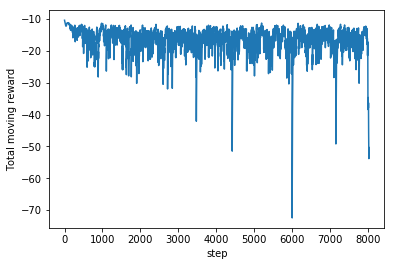

In [1]:
"""
Asynchronous Advantage Actor Critic (A3C) + RNN with continuous action space, Reinforcement Learning.

The Pendulum example.

View more on my tutorial page: https://morvanzhou.github.io/tutorials/

Using:
tensorflow 1.0
gym 0.8.0
"""

import multiprocessing
import threading
import tensorflow as tf
import numpy as np
import gym
import os
import shutil
import matplotlib.pyplot as plt

GAME = 'BipedalWalkerHardcore-v2'
Train = True
OUTPUT_GRAPH = True
LOG_DIR = './log'
N_WORKERS = multiprocessing.cpu_count()
MAX_EP_STEP = 400
MAX_GLOBAL_EP = 8000
CHECKPOINT_INTERVAL = 3000
CHECKPOINT_SAVE_PATH = "/tmp/"+"a3c_rnn"+".ckpt"
GLOBAL_NET_SCOPE = 'Global_Net'
UPDATE_GLOBAL_ITER = 5
GAMMA = 0.9
ENTROPY_BETA = 0.01
LR_A = 0.0001    # learning rate for actor
LR_C = 0.001    # learning rate for critic
GLOBAL_RUNNING_R = []
GLOBAL_EP = 0

env = gym.make(GAME)

N_S = env.observation_space.shape[0]
N_A = env.action_space.shape[0]
A_BOUND = [env.action_space.low, env.action_space.high]


class ACNet(object):
    def __init__(self, scope, globalAC=None):

        if scope == GLOBAL_NET_SCOPE:   # get global network
            with tf.variable_scope(scope):
                self.s = tf.placeholder(tf.float32, [None, N_S], 'S')
                self._build_net()
                self.a_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/actor')
                self.c_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/critic')
        else:   # local net, calculate losses
            with tf.variable_scope(scope):
                self.s = tf.placeholder(tf.float32, [None, N_S], 'S')
                self.a_his = tf.placeholder(tf.float32, [None, N_A], 'A')
                self.v_target = tf.placeholder(tf.float32, [None, 1], 'Vtarget')

                mu, sigma, self.v = self._build_net()

                td = tf.subtract(self.v_target, self.v, name='TD_error')
                with tf.name_scope('c_loss'):
                    self.c_loss = tf.reduce_mean(tf.square(td))

                with tf.name_scope('wrap_a_out'):
                    mu, sigma = mu * A_BOUND[1], sigma + 1e-4

                normal_dist = tf.contrib.distributions.Normal(mu, sigma)

                with tf.name_scope('a_loss'):
                    log_prob = normal_dist.log_prob(self.a_his)
                    exp_v = log_prob * td
                    entropy = normal_dist.entropy()  # encourage exploration
                    self.exp_v = ENTROPY_BETA * entropy + exp_v
                    self.a_loss = tf.reduce_mean(-self.exp_v)

                with tf.name_scope('choose_a'):  # use local params to choose action
                    self.A = tf.clip_by_value(tf.squeeze(normal_dist.sample(1), axis=0), A_BOUND[0], A_BOUND[1])
                with tf.name_scope('local_grad'):
                    self.a_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/actor')
                    self.c_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/critic')
                    self.a_grads = tf.gradients(self.a_loss, self.a_params)
                    self.c_grads = tf.gradients(self.c_loss, self.c_params)

            with tf.name_scope('sync'):
                with tf.name_scope('pull'):
                    self.pull_a_params_op = [l_p.assign(g_p) for l_p, g_p in zip(self.a_params, globalAC.a_params)]
                    self.pull_c_params_op = [l_p.assign(g_p) for l_p, g_p in zip(self.c_params, globalAC.c_params)]
                if Train:
                    with tf.name_scope('push'):
                        self.update_a_op = OPT_A.apply_gradients(zip(self.a_grads, globalAC.a_params))
                        self.update_c_op = OPT_C.apply_gradients(zip(self.c_grads, globalAC.c_params))

    def _build_net(self):
        w_init = tf.random_normal_initializer(0., .1)
        with tf.variable_scope('critic'):   # only critic controls the rnn update
            cell_size = 256
            s = tf.expand_dims(self.s, axis=1,
                               name='timely_input')  # [time_step, feature] => [time_step, batch, feature]
            rnn_cell = tf.contrib.rnn.BasicRNNCell(cell_size)
            self.init_state = rnn_cell.zero_state(batch_size=1, dtype=tf.float32)
            outputs, self.final_state = tf.nn.dynamic_rnn(
                cell=rnn_cell, inputs=s, initial_state=self.init_state, time_major=True)
            cell_out = tf.reshape(outputs, [-1, cell_size], name='flatten_rnn_outputs')  # joined state representation
            l_c = tf.layers.dense(cell_out, 256, tf.nn.relu6, kernel_initializer=w_init, name='lc')
            v = tf.layers.dense(l_c, 1, kernel_initializer=w_init, name='v')  # state value

        with tf.variable_scope('actor'):  # state representation is based on critic
            cell_out = tf.stop_gradient(cell_out, name='c_cell_out')    # from what critic think it is
            l_a = tf.layers.dense(cell_out, 256, tf.nn.relu6, kernel_initializer=w_init, name='la')
            mu = tf.layers.dense(l_a, N_A, tf.nn.tanh, kernel_initializer=w_init, name='mu')
            sigma = tf.layers.dense(l_a, N_A, tf.nn.softplus, kernel_initializer=w_init, name='sigma')
        return mu, sigma, v

    def update_global(self, feed_dict):  # run by a local
        SESS.run([self.update_a_op, self.update_c_op], feed_dict)  # local grads applies to global net

    def pull_global(self):  # run by a local
        SESS.run([self.pull_a_params_op, self.pull_c_params_op])

    def choose_action(self, s, cell_state):  # run by a local
        s = s[np.newaxis, :]
        a, cell_state = SESS.run([self.A, self.final_state], {self.s: s, self.init_state: cell_state})
        return a[0], cell_state


class Worker(object):
    def __init__(self, name, globalAC):
        self.env = gym.make(GAME).unwrapped
        self.name = name
        self.AC = ACNet(name, globalAC)

    def work(self, saver):
        global GLOBAL_RUNNING_R, GLOBAL_EP
        total_step = 1
        buffer_s, buffer_a, buffer_r = [], [], []
        while not COORD.should_stop() and GLOBAL_EP < MAX_GLOBAL_EP:
            s = self.env.reset()
            ep_r = 0
            rnn_state = SESS.run(self.AC.init_state)    # zero rnn state at beginning
            #keep_state = rnn_state.copy()       # keep rnn state for updating global net
            while True:
                if self.name == 'W_0':
                    self.env.render()

                a, rnn_state_ = self.AC.choose_action(s, rnn_state)  # get the action and next rnn state
                s_, r, done, info = self.env.step(a)
                #done = True if ep_t == MAX_EP_STEP - 1 else False
                r /= 10     # normalize reward

                ep_r += r
                buffer_s.append(s)
                buffer_a.append(a)
                buffer_r.append(r)

                if total_step % UPDATE_GLOBAL_ITER == 0 or done:   # update global and assign to local net
                    if done:
                        v_s_ = 0   # terminal
                    else:
                        v_s_ = SESS.run(self.AC.v, {self.AC.s: s_[np.newaxis, :], self.AC.init_state: rnn_state_})[0, 0]
                    buffer_v_target = []
                    for r in buffer_r[::-1]:    # reverse buffer r
                        v_s_ = r + GAMMA * v_s_
                        buffer_v_target.append(v_s_)
                    buffer_v_target.reverse()

                    buffer_s, buffer_a, buffer_v_target = np.vstack(buffer_s), np.vstack(buffer_a), np.vstack(buffer_v_target)

                    feed_dict = {
                        self.AC.s: buffer_s,
                        self.AC.a_his: buffer_a,
                        self.AC.v_target: buffer_v_target,
                        self.AC.init_state: rnn_state,
                    }

                    self.AC.update_global(feed_dict)
                    buffer_s, buffer_a, buffer_r = [], [], []
                    self.AC.pull_global()
                    #keep_state = rnn_state_.copy()   # replace the keep_state as the new initial rnn state_

                s = s_
                rnn_state = rnn_state_  # renew rnn state
                total_step += 1

                if done:
                    if len(GLOBAL_RUNNING_R) == 0:  # record running episode reward
                        GLOBAL_RUNNING_R.append(ep_r)
                    else:
                        GLOBAL_RUNNING_R.append(0.9 * GLOBAL_RUNNING_R[-1] + 0.1 * ep_r)
                    print(
                        self.name,
                        "Ep:", GLOBAL_EP,
                        "| Ep_r: %i" % GLOBAL_RUNNING_R[-1],
                          )
                    GLOBAL_EP += 1
                    if GLOBAL_EP % CHECKPOINT_INTERVAL == 0:
                        saver.save(SESS, CHECKPOINT_SAVE_PATH, global_step = GLOBAL_EP)
                    break

if __name__ == "__main__":
    SESS = tf.Session()
    
    if Train:
        with tf.device("/cpu:0"):
            OPT_A = tf.train.RMSPropOptimizer(LR_A, name='RMSPropA')
            OPT_C = tf.train.RMSPropOptimizer(LR_C, name='RMSPropC')
            GLOBAL_AC = ACNet(GLOBAL_NET_SCOPE)  # we only need its params
            workers = []
            # Create worker
            for i in range(N_WORKERS):
                i_name = 'W_%i' % i   # worker name
                workers.append(Worker(i_name, GLOBAL_AC))

        COORD = tf.train.Coordinator()
        SESS.run(tf.global_variables_initializer())

        if OUTPUT_GRAPH:
            if os.path.exists(LOG_DIR):
                shutil.rmtree(LOG_DIR)
            tf.summary.FileWriter(LOG_DIR, SESS.graph)


        reuse_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=GLOBAL_NET_SCOPE )
        reuse_vars_dict = dict([(var.name, var) for var in reuse_vars])
        print(reuse_vars_dict)
        saver = tf.train.Saver(reuse_vars_dict)

        worker_threads = []
        for worker in workers:
            job = lambda: worker.work(saver)
            t = threading.Thread(target=job)
            t.start()
            worker_threads.append(t)
        COORD.join(worker_threads)

        plt.plot(np.arange(len(GLOBAL_RUNNING_R)), GLOBAL_RUNNING_R)
        plt.xlabel('step')
        plt.ylabel('Total moving reward')
        plt.show()
    else:
        with tf.device("/cpu:0"):
            GLOBAL_AC = ACNet(GLOBAL_NET_SCOPE)  # we only need its params
            LOCAL_AC = ACNet('ww', GLOBAL_AC)
            
        reuse_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=GLOBAL_NET_SCOPE )
        reuse_vars_dict = dict([(var.name, var) for var in reuse_vars])
        print(reuse_vars_dict)
        saver = tf.train.Saver(reuse_vars_dict)
        saver.restore(SESS, "/tmp/"+'a3c_rnn.ckpt-6000')
        
        
        env = gym.wrappers.Monitor(env, '/tmp/BipedalWalkerHardcore-v2',force=True)
        rnn_state = SESS.run(GLOBAL_AC.init_state)
        LOCAL_AC.pull_global()
        for i_episode in range(20):
            observation = env.reset()
            done = False
            t = 0
            while not done:
                t += 1
                env.render()
                #print(observation)
                action, rnn_state_ = LOCAL_AC.choose_action(observation, rnn_state)  # get the action and next rnn state
                observation, reward, done, info = env.step(action)
                if done:
                    print("Episode finished after {} timesteps".format(t+1))
                    t = 0
                    break

            